In [1]:
import os
from datetime import datetime
#from datetime import date``
import pymysql
from sqlalchemy import create_engine, text
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
from numpy import int16
from enum import Enum
from dataframe_image import export
from datetime import datetime


In [2]:
# Using enum class create enumerations
class Constante(Enum):
   glob = ""
   specific = "2024-01-01"
   end = datetime.today().strftime("%Y-%m-%d")


In [3]:
load_dotenv("../actual_caris_host.env")
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')
# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    agent_username, COUNT(*) AS nbre,
    dsd.organisation,
    dsd.timeEnd as entry_date
FROM
    caris_db.dreams_surveys_data dsd
WHERE
    dsd.timeEnd >= '{Constante.specific.value}'
    and
    dsd.timeEnd <= '{Constante.end.value}'
GROUP BY agent_username
'''
agent = pd.read_sql_query(text(query),engine.connect(),parse_dates=True)
# get the test excel file from Query
# close the pool of connection
engine.dispose()


## Agent DREAMS sortant du Systeme

In [4]:
agent.rename(columns={'agent_username':'username'},inplace=True)


In [5]:
agent


,username,nbre,organisation,entry_date
0,2fabrice,108,Caris,2024-01-12 20:57:02
1,2billy,129,Caris,2024-02-15 16:25:02
2,cmariedanielle,40,Caris,2024-02-23 15:26:43
3,6chelot,130,Caris,2024-01-16 19:56:13
4,2sfenelon,4,Caris,2024-02-22 19:45:01
5,1mondesir,36,Caris,2024-01-14 18:40:45
6,2eliona,18,Caris,2024-01-12 21:13:34
7,2richecarde,34,Caris,2024-02-22 17:33:47
8,2diegoarmando,51,Caris,2024-02-21 16:40:22
9,2jules,12,Caris,2024-02-23 19:19:40


In [6]:
agent_name = pd.read_excel("caris-test_users_48427203a28d49ffa90cba1a8d5f2ff6.xlsx")
agent_past_data = pd.read_excel("performance_formulaire_denrolement.xlsx")


In [7]:
agent_name = agent_name[["username","name"]]


## Liste de tous les agents avec Leur nom

In [8]:
agent_name


,username,name
0,1aldonzar,elcie aldonzar
1,1annuelle,Annuelle Eustache
2,1blenzaire,Blenzaire Etienne
3,1bycinthe,Roberthe Bycinthe
4,1chrislyne,Chrislyne Bien Aimée
...,...,...
865,vvillard,Vilner Villard
866,wbeauplan,Willins Beauplan
867,yandre,Yves Andre
868,yvon,Yvon Antoine


In [9]:
agent_name = agent_name.merge(agent,on="username",how="inner")

In [10]:
agent_name.sort_values(by=['nbre'],ascending=False,inplace=True)

In [11]:
agent_name

,username,name,nbre,organisation,entry_date
12,6chelot,Chelot Demosthene,130,Caris,2024-01-16 19:56:13
1,2billy,Billy jolicoeur,129,Caris,2024-02-15 16:25:02
5,2fabrice,Fabrice Byron,108,Caris,2024-01-12 20:57:02
11,2woodridchard,Wood-Ridchard Bon,77,Caris,2024-01-24 16:10:59
18,6frazyouseline,Fraz-Youseline Dorcent,56,Caris,2024-01-25 01:52:02
3,2diegoarmando,Diego Armando Dorlean,51,Caris,2024-02-21 16:40:22
6,2gerald,Gerald Poteau,43,Caris,2024-02-23 15:18:17
14,cmariedanielle,Marie Danielle Cazy,40,Caris,2024-02-23 15:26:43
0,1mondesir,Elande Mondésir,36,Caris,2024-01-14 18:40:45
8,2richecarde,Richecarde Moreau,34,Caris,2024-02-22 17:33:47


In [12]:
agent_past_data = agent_past_data[["username","nbre"]]


In [13]:
agent_past_data.rename(columns={'nbre':'past_entry'},inplace=True)


In [14]:
agent_name = agent_name.merge(agent_past_data,on="username",how="left")
agent_name.fillna(0,inplace=True)


In [15]:
agent_name['nbre_new_entry'] = agent_name['nbre'] - agent_name['past_entry']


In [16]:
agent_name


,username,name,nbre,organisation,entry_date,past_entry,nbre_new_entry
0,6chelot,Chelot Demosthene,130,Caris,2024-01-16 19:56:13,130.0,0.0
1,2billy,Billy jolicoeur,129,Caris,2024-02-15 16:25:02,129.0,0.0
2,2fabrice,Fabrice Byron,108,Caris,2024-01-12 20:57:02,108.0,0.0
3,2woodridchard,Wood-Ridchard Bon,77,Caris,2024-01-24 16:10:59,77.0,0.0
4,6frazyouseline,Fraz-Youseline Dorcent,56,Caris,2024-01-25 01:52:02,56.0,0.0
5,2diegoarmando,Diego Armando Dorlean,51,Caris,2024-02-21 16:40:22,51.0,0.0
6,2gerald,Gerald Poteau,43,Caris,2024-02-23 15:18:17,43.0,0.0
7,cmariedanielle,Marie Danielle Cazy,40,Caris,2024-02-23 15:26:43,40.0,0.0
8,1mondesir,Elande Mondésir,36,Caris,2024-01-14 18:40:45,36.0,0.0
9,2richecarde,Richecarde Moreau,34,Caris,2024-02-22 17:33:47,0.0,34.0


In [17]:
agent_name = agent_name[['username','name','nbre','nbre_new_entry','organisation','entry_date']]


In [18]:
agent_name.nbre_new_entry = agent_name.nbre_new_entry.astype(int)


/var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/ipykernel_60898/3287235938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_name.nbre_new_entry = agent_name.nbre_new_entry.astype(int)


In [19]:
agent_name


,username,name,nbre,nbre_new_entry,organisation,entry_date
0,6chelot,Chelot Demosthene,130,0,Caris,2024-01-16 19:56:13
1,2billy,Billy jolicoeur,129,0,Caris,2024-02-15 16:25:02
2,2fabrice,Fabrice Byron,108,0,Caris,2024-01-12 20:57:02
3,2woodridchard,Wood-Ridchard Bon,77,0,Caris,2024-01-24 16:10:59
4,6frazyouseline,Fraz-Youseline Dorcent,56,0,Caris,2024-01-25 01:52:02
5,2diegoarmando,Diego Armando Dorlean,51,0,Caris,2024-02-21 16:40:22
6,2gerald,Gerald Poteau,43,0,Caris,2024-02-23 15:18:17
7,cmariedanielle,Marie Danielle Cazy,40,0,Caris,2024-02-23 15:26:43
8,1mondesir,Elande Mondésir,36,0,Caris,2024-01-14 18:40:45
9,2richecarde,Richecarde Moreau,34,34,Caris,2024-02-22 17:33:47


## MERGE (Vlookup)

In [20]:
performanceAgents = agent_name


In [21]:
performanceAgents.nbre.sum()


803

In [22]:
performanceAgents

,username,name,nbre,nbre_new_entry,organisation,entry_date
0,6chelot,Chelot Demosthene,130,0,Caris,2024-01-16 19:56:13
1,2billy,Billy jolicoeur,129,0,Caris,2024-02-15 16:25:02
2,2fabrice,Fabrice Byron,108,0,Caris,2024-01-12 20:57:02
3,2woodridchard,Wood-Ridchard Bon,77,0,Caris,2024-01-24 16:10:59
4,6frazyouseline,Fraz-Youseline Dorcent,56,0,Caris,2024-01-25 01:52:02
5,2diegoarmando,Diego Armando Dorlean,51,0,Caris,2024-02-21 16:40:22
6,2gerald,Gerald Poteau,43,0,Caris,2024-02-23 15:18:17
7,cmariedanielle,Marie Danielle Cazy,40,0,Caris,2024-02-23 15:26:43
8,1mondesir,Elande Mondésir,36,0,Caris,2024-01-14 18:40:45
9,2richecarde,Richecarde Moreau,34,34,Caris,2024-02-22 17:33:47


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [24]:
from datetime import datetime
date_du_jour = datetime.today().strftime("%d_%m_%Y")


In [25]:
orderdata = performanceAgents.nbre.sort_values().to_list()


/var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/ipykernel_60898/605691686.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)


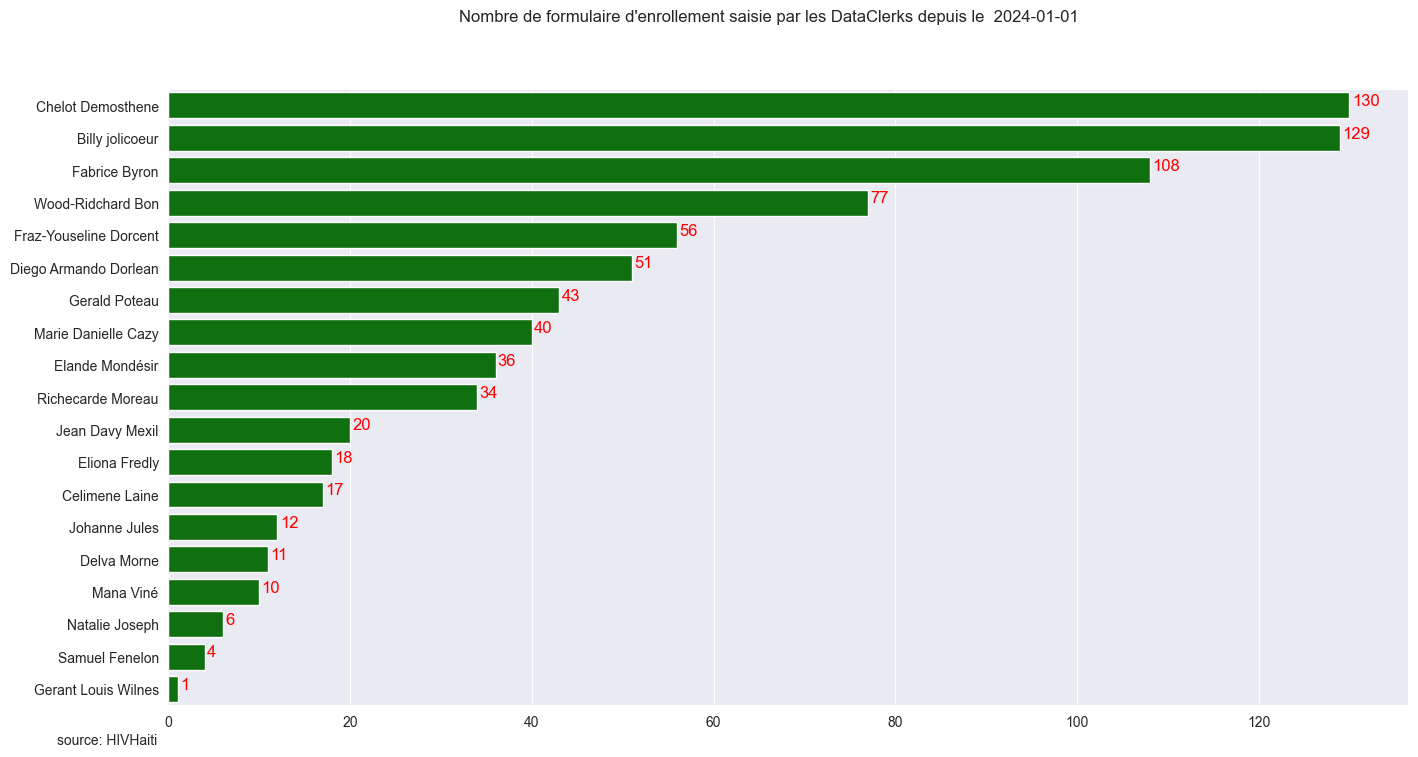

In [26]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de formulaire d'enrollement saisie par les DataClerks depuis le  {Constante.specific.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )

    #plt.savefig(f"saisie_screening_{date_du_jour}",dpi=1000)
except ValueError:
    print("No data is avalaible")


In [27]:
performanceAgents.nbre.sum()


803

In [28]:
performanceAgents.nbre_new_entry.sum()

40

In [29]:
performanceAgents.to_excel(f"performance_formulaire_denrolement.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_{date_du_jour}.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_depuis_1Mars2021.xlsx",index=False,na_rep="NULL")